In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from datetime import datetime, date
from trainline_traffic_counter_mapping import generate_trainline_counter_mapping
from data_transform_utils import get_weekday_traffic_deviations, get_avg_weekday_traffic_deviations, get_punctuality_of_year

# TRAINLINE_NAME = 'RB 84: Kiel - Lübeck'
# TRAINLINE_NAME = 'RB 63: Büsum - Neumünster'
# TRAINLINE_NAME = 'RB 85: Puttgarden - Lübeck'
TRAINLINE_NAME = 'RB 62: Heide - Itzehoe'

train_counter_mapping = generate_trainline_counter_mapping()
traffic_counters = train_counter_mapping.get(TRAINLINE_NAME)
print(traffic_counters)

traffic_cnt_engines = []
for traffic_counter in traffic_counters:
    eng = create_engine('sqlite:///../../data/traffic_counter_' + str(traffic_counter) + '.sqlite')
    eng.counter_name = str(traffic_counter)
    traffic_cnt_engines.append(eng)
    
trainline_punc_engine = create_engine('sqlite:///../../data/train_punctuality.sqlite')






[1270, 1269, 1163, 1268, 1197, 1178]


Correlation for counter 1163 in the year 2012 : -0.007584848314801704 (p-val: 0.9813355940684547 )
Correlation for counter 1197 in the year 2012 : 0.1088938110252778 (p-val: 0.7362110818893163 )
Correlation for counter 1178 in the year 2012 : 0.18289851341785948 (p-val: 0.5693790041960504 )
Avg year correlation: 0.09473582537611186
Avg year p-value: 0.7623085600512738


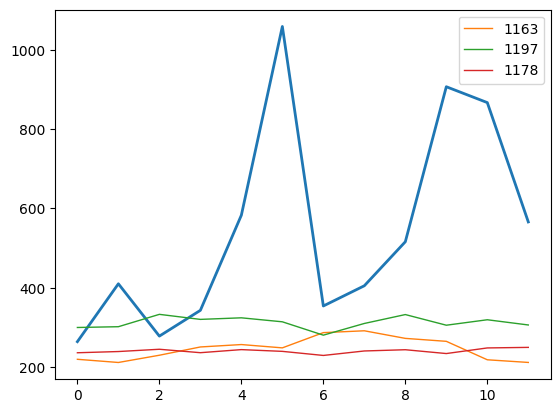

In [2]:
import matplotlib.pyplot as plt

for year in range(2012, 2013):
    all_cntrs_mon_variance = [[] for i in range(12)]
    
    
        
    trainline_punc_df = pd.read_sql_table(TRAINLINE_NAME, trainline_punc_engine)
    monthly_punc_dict = get_punctuality_of_year(trainline_punc_df, year)
    lateness_list = []
    for i in range(12):
        DEFAULT_VALUE = 0
        lateness_list.append(100.0 - monthly_punc_dict.get(i+1, DEFAULT_VALUE))
    
    SCALE_FACTOR = 100
    plt.plot([lateness_val * SCALE_FACTOR for lateness_val in lateness_list], linewidth=2.0)
    
    yearly_avg_corr_values = []
    yearly_avg_p_values = []
    for counter_db in traffic_cnt_engines:
        try:
            df = pd.read_sql_table(str(year), counter_db)
        except ValueError:
            continue
        monthly_weekday_variances = get_avg_weekday_traffic_deviations(df)
        
        counter_year_corr, counter_year_p_val = pearsonr(lateness_list, monthly_weekday_variances)
        print('Correlation for counter', counter_db.counter_name, 'in the year', year, ':', counter_year_corr, '(p-val:', counter_year_p_val, ')')
        yearly_avg_corr_values.append(counter_year_corr)
        yearly_avg_p_values.append(counter_year_p_val)
        
        plt.plot(monthly_weekday_variances, linewidth=1.0, label=counter_db.counter_name)


    # Calculate correlation averages
    yearly_avg_corr = sum(yearly_avg_corr_values) / len(yearly_avg_corr_values)
    yearly_avg_p_value = sum(yearly_avg_p_values) / len(yearly_avg_p_values)

    print('Avg year correlation:', yearly_avg_corr)
    print('Avg year p-value:', yearly_avg_p_value)

plt.legend()



In [8]:
import matplotlib.pyplot as plt

for year in range(2012, 2019):
    # all_cntrs_mon_variance = [[] for i in range(12)]
    all_cntrs_mon_variance = [0] * 12
    # print('Init all_cntrs_mon_variance:', all_cntrs_mon_variance)
    
    # plt.plot(lateness_list, linewidth=2.0)
    
    # yearly_avg_corr_values = []
    # yearly_avg_p_values = []
    for counter_db in traffic_cnt_engines:
        try:
            df = pd.read_sql_table(str(year), counter_db)
        except ValueError:
            # No value for that year for that counter
            continue
        monthly_weekday_variances = get_avg_weekday_traffic_deviations(df)
        # Add monthly avg weekday variances to all counter weekday variances
        # print('Before: all_cntrs_mon_variance=', all_cntrs_mon_variance, 'monthly variance of counter:', monthly_weekday_variances)
        for i in range(12):
            all_cntrs_mon_variance[i] += monthly_weekday_variances[i]
        # print('After: all_cntrs_mon_variance')
            
        # counter_year_corr, counter_year_p_val = pearsonr(lateness_list, monthly_weekday_variances)
        # print('Correlation for counter', counter_db.name, 'in the year', year, ':', counter_year_corr, '(p-val:', counter_year_p_val, ')')
        # yearly_avg_corr_values.append(counter_year_corr)
        # yearly_avg_p_values.append(counter_year_p_val)
        
        # plt.plot(monthly_weekday_variances, linewidth=1.0, label=counter_db.counter_name)

    
    trainline_punc_df = pd.read_sql_table(TRAINLINE_NAME, trainline_punc_engine)
    monthly_punc_dict = get_punctuality_of_year(trainline_punc_df, year)
    lateness_list = []
    for i in range(12):
        DEFAULT_VALUE = 0
        SCALE_FACTOR = 1
        lateness_list.append(SCALE_FACTOR * (100.0 - monthly_punc_dict.get(i+1, DEFAULT_VALUE)))
    
    # Calc correlation of all counters monthly variances and train lateness
    all_cntrs_corr, all_cntrs_p_val = pearsonr(all_cntrs_mon_variance, lateness_list)
    print('All counters avg weekday var:', all_cntrs_mon_variance)
    print('Correlation:', all_cntrs_corr, 'p-value:', all_cntrs_p_val)
    

# plt.legend()



All counters avg weekday var: [1576.677904203781, 1548.3424784359659, 1720.4773378207635, 1930.3632866621106, 2063.994236121635, 2170.7826341071823, 2583.729146558939, 2401.3055495346453, 2042.6830002347986, 1874.0734301439732, 1630.4373960824043, 1525.8805026923642]
Correlation: 0.6397154494581923 p-value: 0.025077523106899657
All counters avg weekday var: [1503.2559566498376, 1567.1681956331108, 1672.959891534521, 1795.0140727070448, 2055.058173023688, 2056.7832088894675, 2574.8531151377665, 2456.3811404478392, 2134.032197459266, 2078.2097467401013, 1850.8028469847436, 1706.914177417163]
Correlation: 0.5585897863351753 p-value: 0.05905722189851025
All counters avg weekday var: [1584.3508872671332, 1701.0659433510705, 1882.7292048577401, 2160.236331523609, 2069.405738151897, 2148.669140349347, 2343.7296919921228, 2610.1406440913315, 2334.0393285723544, 2130.300182606049, 1884.8017690833574, 1810.502500692002]
Correlation: 0.4163274421100201 p-value: 0.17823316349507307
All counters av

In [3]:
### Same as before but not all variances added, but the average of all variances

import matplotlib.pyplot as plt

for year in range(2012, 2019):
    # all_cntrs_mon_variance = [[] for i in range(12)]
    all_cntrs_mon_variances = [[] for i in range(12)]
    # print('Init all_cntrs_mon_variance:', all_cntrs_mon_variance)
    
    # plt.plot(lateness_list, linewidth=2.0)
    
    # yearly_avg_corr_values = []
    # yearly_avg_p_values = []
    for counter_db in traffic_cnt_engines:
        try:
            df = pd.read_sql_table(str(year), counter_db)
        except ValueError:
            # No value for that year for that counter
            continue
        monthly_weekday_variances = get_avg_weekday_traffic_deviations(df)
        # Add monthly avg weekday variances to all counter weekday variances
        # print('Before: all_cntrs_mon_variance=', all_cntrs_mon_variance, 'monthly variance of counter:', monthly_weekday_variances)
        for i in range(12):
            all_cntrs_mon_variances[i].append(monthly_weekday_variances[i])
        # print('After: all_cntrs_mon_variance')
            
        # counter_year_corr, counter_year_p_val = pearsonr(lateness_list, monthly_weekday_variances)
        # print('Correlation for counter', counter_db.name, 'in the year', year, ':', counter_year_corr, '(p-val:', counter_year_p_val, ')')
        # yearly_avg_corr_values.append(counter_year_corr)
        # yearly_avg_p_values.append(counter_year_p_val)
        
        # plt.plot(monthly_weekday_variances, linewidth=1.0, label=counter_db.counter_name)

    # Calc avg of all monthly avg variances
    all_cntrs_avg_mon_variance = []
    for variance_averages in all_cntrs_mon_variances:
        avg_variance = sum(variance_averages) / len(variance_averages)
        all_cntrs_avg_mon_variance.append(avg_variance)
    
    trainline_punc_df = pd.read_sql_table(TRAINLINE_NAME, trainline_punc_engine)
    monthly_punc_dict = get_punctuality_of_year(trainline_punc_df, year)
    lateness_list = []
    for i in range(12):
        DEFAULT_VALUE = 0
        SCALE_FACTOR = 1
        lateness_list.append(SCALE_FACTOR * (100.0 - monthly_punc_dict.get(i+1, DEFAULT_VALUE)))
    
    # Calc correlation of all counters monthly variances and train lateness
    all_cntrs_corr, all_cntrs_p_val = pearsonr(all_cntrs_avg_mon_variance, lateness_list)
    print('All counters avg weekday var:', all_cntrs_avg_mon_variance)
    print('Correlation:', all_cntrs_corr, 'p-value:', all_cntrs_p_val)
    

# plt.legend()



All counters avg weekday var: [251.77175281423413, 250.7752383906965, 269.1699761757795, 268.998454634059, 274.9367600968631, 267.332058411608, 265.47599999121024, 280.62093775896864, 282.76721612074965, 268.12070196177564, 261.91295791804146, 255.75853241184282]
Correlation: 0.08147741911376633 p-value: 0.8012534003312173
All counters avg weekday var: [242.85709643811643, 249.48657127796244, 258.32148713738707, 277.2668754526998, 288.1159485204775, 272.41514596196635, 275.89534331941746, 306.2228309247507, 295.5690117751584, 285.75990358997007, 280.2399620765345, 272.72395172878225]
Correlation: 0.27377075658635436 p-value: 0.3892140665139864
All counters avg weekday var: [257.5616011225402, 271.8473096838821, 284.04544337944554, 294.28392627630825, 299.65656801225487, 306.6447575492741, 279.6182020977704, 300.6189338051031, 293.03145798137086, 279.3566388807523, 272.2983049369555, 260.39834921035725]
Correlation: -0.27687096017531604 p-value: 0.3836479674648021
All counters avg weekd

In [4]:
### Instead of variances, simply the average daily traffic per month is used

import matplotlib.pyplot as plt
from data_transform_utils import get_monthly_avg_day_traffic

for year in range(2012, 2019):
    # all_cntrs_mon_variance = [[] for i in range(12)]
    all_cntrs_mon_traffic = [[] for i in range(12)]
    # print('Init all_cntrs_mon_variance:', all_cntrs_mon_variance)
    
    # plt.plot(lateness_list, linewidth=2.0)
    
    # yearly_avg_corr_values = []
    # yearly_avg_p_values = []
    for counter_db in traffic_cnt_engines:
        try:
            df = pd.read_sql_table(str(year), counter_db)
        except ValueError:
            # No value for that year for that counter
            continue
        monthly_traffic = get_monthly_avg_day_traffic(df)
        # Add monthly avg weekday variances to all counter weekday variances
        # print('Before: all_cntrs_mon_variance=', all_cntrs_mon_variance, 'monthly variance of counter:', monthly_weekday_variances)
        for i in range(12):
            all_cntrs_mon_traffic[i].append(monthly_traffic[i])
        # print('After: all_cntrs_mon_variance')
            
        # counter_year_corr, counter_year_p_val = pearsonr(lateness_list, monthly_weekday_variances)
        # print('Correlation for counter', counter_db.name, 'in the year', year, ':', counter_year_corr, '(p-val:', counter_year_p_val, ')')
        # yearly_avg_corr_values.append(counter_year_corr)
        # yearly_avg_p_values.append(counter_year_p_val)
        
        # plt.plot(monthly_weekday_variances, linewidth=1.0, label=counter_db.counter_name)

    # Calc avg of all monthly avg variances
    all_cntrs_avg_mon_traffic = []
    for traffic_averages in all_cntrs_mon_traffic:
        avg_traffic = sum(traffic_averages) / len(traffic_averages)
        all_cntrs_avg_mon_traffic.append(avg_traffic)
    
    trainline_punc_df = pd.read_sql_table(TRAINLINE_NAME, trainline_punc_engine)
    monthly_punc_dict = get_punctuality_of_year(trainline_punc_df, year)
    lateness_list = []
    for i in range(12):
        DEFAULT_VALUE = 0
        SCALE_FACTOR = 1
        lateness_list.append(SCALE_FACTOR * (100.0 - monthly_punc_dict.get(i+1, DEFAULT_VALUE)))
    
    # Calc correlation of all counters monthly variances and train lateness
    all_cntrs_corr, all_cntrs_p_val = pearsonr(all_cntrs_avg_mon_traffic, lateness_list)
    print('All counters avg weekday var:', all_cntrs_avg_mon_traffic)
    print('Correlation:', all_cntrs_corr, 'p-value:', all_cntrs_p_val)
    

# plt.legend()



All counters avg weekday var: [451.78091397849465, 465.6494252873563, 519.0224014336917, 508.1370370370371, 541.7822580645162, 536.4277777777778, 547.5282258064517, 591.7069892473119, 562.6185185185185, 520.6913082437276, 496.7245370370371, 434.63933691756273]
Correlation: 0.09588710409506461 p-value: 0.7668968067840825
All counters avg weekday var: [432.9318996415771, 459.7232142857142, 472.18548387096774, 543.0916666666667, 558.7876344086021, 546.2231481481482, 583.9462365591397, 647.7329749103943, 595.4319444444444, 569.0985663082438, 529.9467592592592, 473.8660394265233]
Correlation: 0.2067625522008454 p-value: 0.519080674377862
All counters avg weekday var: [472.5546594982079, 508.21775793650795, 544.5416666666666, 576.1402777777778, 591.4117383512545, 608.9587962962963, 586.3494623655914, 633.1971326164875, 592.8375000000001, 558.586917562724, 514.924074074074, 475.584229390681]
Correlation: -0.1729346101855736 p-value: 0.5909385626727066
All counters avg weekday var: [415.706451

[[4334.421703064897, 4232.245420577592, 3600.860823007002, 3943.9533782741396, 2848.155587393357, 1920.5702278229764, 4130.281503723445], [667.7100168985536, 552.213953101513, 9006.423862999121, 708.7684153986171, 2564.902077403086, 1648.1683520401266, 2248.3132937085675], [660.4263774259778, 351.71330654383837, 1159.2812068979065, 9917.762383723459, 399.75454969268327, 2158.616987795658, 2312.0477756021105], [10959.217618060151, 1836.9294125432982, 2032.68416549809, 2081.041486051315, 15924.170695308856, 3298.5596225221298, 1967.1258729425529], [9624.864916800998, 9466.981530561892, 2858.4654449546874, 13215.8631311012, 7948.140621134816, 2295.053521525515, 2136.17953365348], [857.1291229058393, 1974.6922967051516, 2464.6205083136024, 2585.532246946458, 10338.214304221015, 3133.242218533384, 3222.015970889447], [1313.3523137376353, 1963.0551444113842, 1116.586912574804, 1175.7228627529535, 827.173903521301, 1560.4581592169227, 1058.3480051476452], [450.3971395705498, 924.319749870141,

<Figure size 1200x600 with 0 Axes>

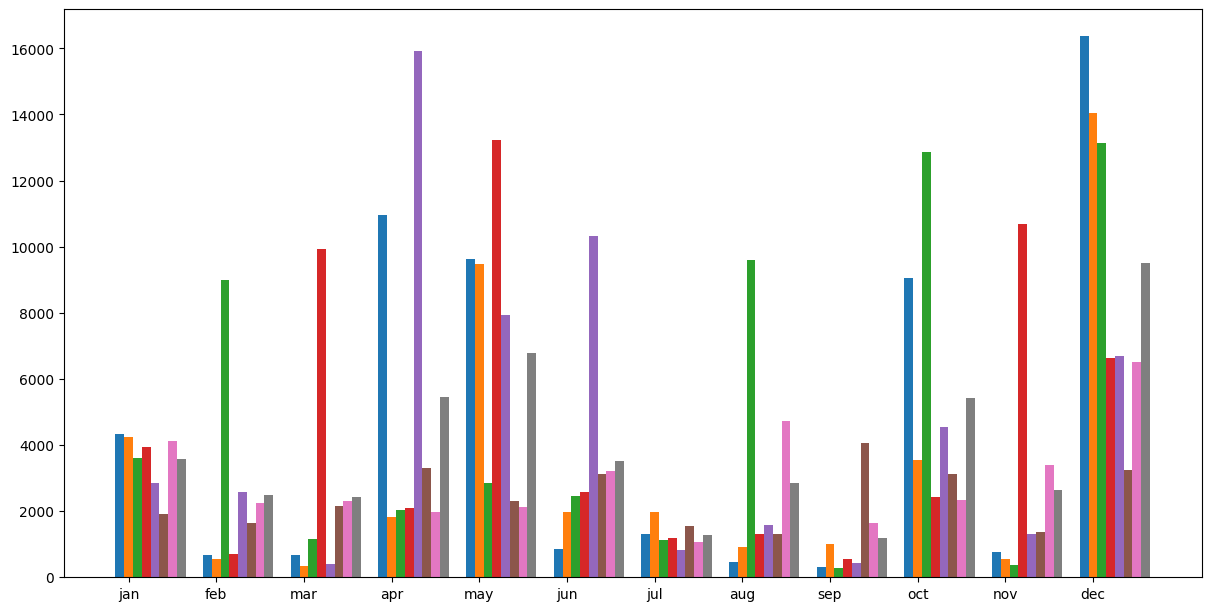

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# From https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
months = ('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec')
weekday_variances = {'mo': [], 'tu': [], 'we': [], 'th':[], 'fr':[], 'sa':[], 'su':[], 'avg': []}
# for day in range(len(weekday_variances)):
for m in range(len(monthly_weekday_variances)):
    weekday_variances['mo'].append(monthly_weekday_variances[m][0])
    weekday_variances['tu'].append(monthly_weekday_variances[m][1])
    weekday_variances['we'].append(monthly_weekday_variances[m][2])
    weekday_variances['th'].append(monthly_weekday_variances[m][3])
    weekday_variances['fr'].append(monthly_weekday_variances[m][4])
    weekday_variances['sa'].append(monthly_weekday_variances[m][5])
    weekday_variances['su'].append(monthly_weekday_variances[m][6])
    avg = sum(monthly_weekday_variances[m]) / len(monthly_weekday_variances[m])
    weekday_variances['avg'].append(avg)
    
print(monthly_weekday_variances)
    
x = np.arange(len(months))
mult = 0

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(layout='constrained', figsize=(12, 6))

for weekday, variance in weekday_variances.items():
    width = 0.1
    off = width * mult
    rects = ax.bar(x + off, variance, width, label=weekday)
    # ax.bar_label(rects)
    mult += 1
    
ax.set_xticks(x + width, months)

plt.show()
